In [1]:
using Turing
using DataFrames
using CSV
using Random
using Distributions
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using StatsPlots
using StatsBase
using FreqTables
using Logging

default(label=false)
Logging.disable_logging(Logging.Warn);

# 12.1 Over-dispersed counts

Code 12.1

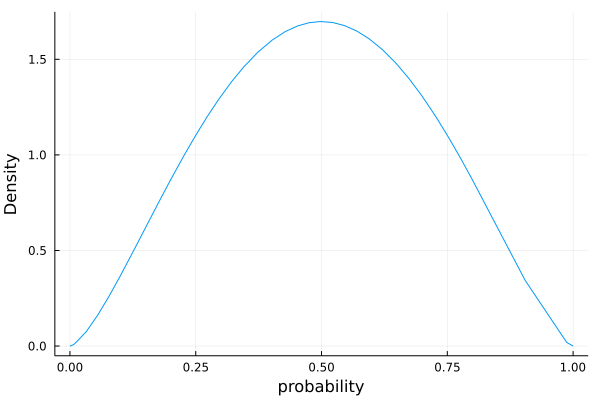

In [2]:
# define alias for Beta(α, β), see: https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size
Beta2(μ, ν) = Beta(μ*ν, (1-μ)*ν)
BetaBinomial2(n, μ, ν) = BetaBinomial(n, μ*ν, (1-μ)*ν)

p̄ = 0.5
θ = 5
plot(Beta2(p̄, θ), xlab="probability", ylab="Density")

Code 12.2

In [3]:
d = DataFrame(CSV.File("data/UCBadmit.csv", skipto=2, 
        header=[:id, :dept, :gender, :admit, :reject, :applications]))

d.gid = @. ifelse(d.gender == "male", 1, 2)

@model function m12_1(A, N, gid)
    a ~ MvNormal([0, 0], 1.5)
    p̄ = @. logistic(a[gid])
    ϕ ~ Exponential(1)
    θ = ϕ + 2
    @. A ~ BetaBinomial2(N, p̄, θ)
end

Random.seed!(1)
m12_1_ch = sample(m12_1(d.admit, d.applications, d.gid), NUTS(), 1000)
m12_1_df = DataFrame(m12_1_ch);

Code 12.3

In [4]:
m12_1_df.θ = m12_1_df.ϕ .+ 2
m12_1_df.da = m12_1_df."a[1]" .- m12_1_df."a[2]"
precis(m12_1_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.4218  0.3935  -1.0357  -0.4374  0.2071  ▁▁▂▄▆█▇▆▄▂▁▁▁▁ │
│  a[2] │  -0.326  0.4014  -0.9482  -0.3262  0.3537          ▁▁▅█▃▁ │
│     ϕ │  1.0505  0.8115   0.1089   0.8704  2.4536     ██▆▄▂▁▁▁▁▁▁ │
│     θ │  3.0505  0.8115   2.1089   2.8704  4.4536     ██▆▄▂▁▁▁▁▁▁ │
│    da │ -0.0958  0.5832   -0.994  -0.0992  0.8353       ▁▁▂▆██▄▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 12.4

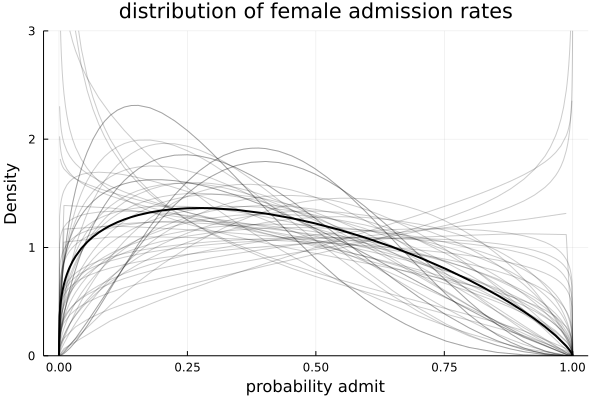

In [5]:
gid = 2
p̄ = m12_1_df[:, "a[$gid]"] .|> logistic |> mean
θ = mean(m12_1_df.θ)
plot(Beta2(p̄, θ), lw=2, c=:black, ylab="Density", 
    xlab="probability admit", ylims=(0, 3))

for (a, θ) ∈ first(zip(m12_1_df[:, "a[$gid]"], m12_1_df.θ), 50)
    plot!(Beta2(logistic(a), θ), c=:black, alpha=0.2)
end
gender = gid == 2 ? "female" : "male"
title!("distribution of $gender admission rates")

Code 12.5

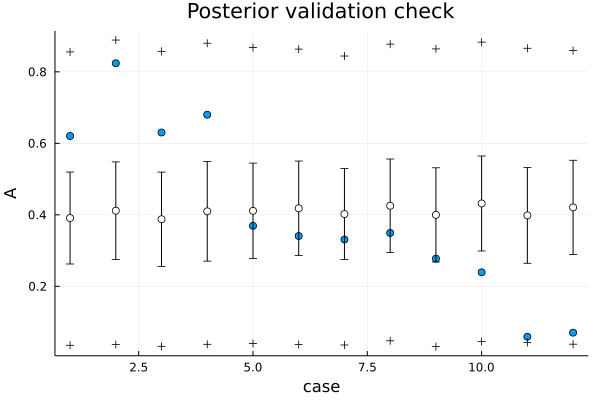

In [6]:
Random.seed!(1)

adm_rate = d.admit ./ d.applications

fun = (r, (N, gid)) -> begin
    p̄ = logistic(get(r, "a[$gid]", 0))
    rand(BetaBinomial2(N, p̄, r.θ))
end

pred_adm = link(m12_1_df, fun, zip(d.applications, d.gid))
pred_rates = pred_adm ./ d.applications

μ_adm = mean.(pred_rates)
σ = std.(pred_rates) ./ 2
ci_adm = PI.(pred_rates)

scatter(adm_rate, xlab="case", ylab="A", title="Posterior validation check")
scatter!(μ_adm, mc=:white, yerr=σ)
scatter!(first.(ci_adm), shape=:cross, c=:black)
scatter!(last.(ci_adm), shape=:cross, c=:black)

Code 12.6

In [7]:
d = DataFrame(CSV.File("data/Kline.csv"))
d.P = standardize(ZScoreTransform, log.(d.population))
d.contact_id = ifelse.(d.contact .== "high", 2, 1)

@model function m12_2(T, P, cid)
    g ~ Exponential()
    ϕ ~ Exponential()
    a ~ MvNormal([1,1], 1)
    b₁ ~ Exponential()
    b₂ ~ Exponential()
    b = [b₁, b₂]
    λ = @. exp(a[cid])*(P^b[cid]) / g
    p = 1/(ϕ+1)
    r = λ/ϕ
    clamp!(r, 0.01, Inf)
    p = clamp(p, 0.01, 1)
    @. T ~ NegativeBinomial(r, p)
end

Random.seed!(1)
m12_2_ch = sample(m12_2(d.total_tools, d.population, d.contact_id), NUTS(), 1000)
m12_2_df = DataFrame(m12_2_ch)
precis(m12_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│  a[1] │ 0.8888  0.7358  -0.3216  0.8937  1.9908   ▁▁▁▁▃▆█▇▆▂▁▁ │
│  a[2] │ 1.0038  0.9476  -0.5036  1.0289  2.4515  ▁▁▁▂▄▆██▇▄▂▁▁ │
│    b₁ │ 0.2572  0.0485   0.1801  0.2571  0.3335       ▁▃▇█▃▁▁▁ │
│    b₂ │ 0.2749   0.122   0.0721  0.2746  0.4691        ▃▅██▃▁▁ │
│     g │ 1.1112  0.7524   0.2547  0.9492   2.577     ▅█▆▃▂▁▁▁▁▁ │
│     ϕ │ 1.2824  0.9127   0.1805  1.0914  2.9921        █▇▃▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


# 12.2 Zero-inflated outcomes

Code 12.7

In [8]:
# define parameters
prob_drink = 0.2 # 20% of days
rate_work = 1    # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
Random.seed!(365)
drink = rand(Binomial(1, prob_drink), N)

# simulate manuscripts completed
y = (1 .- drink).*rand(Poisson(rate_work), N);

Code 12.8

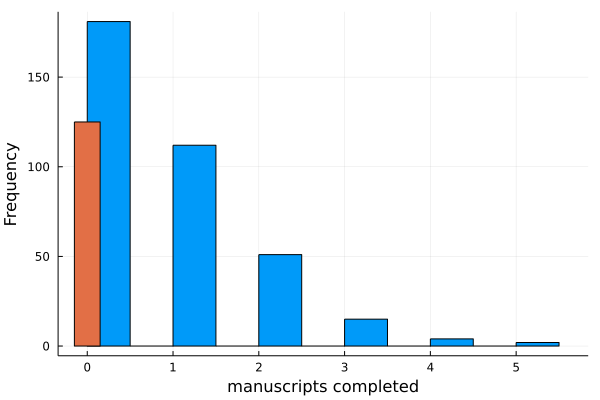

In [9]:
p = histogram(y, xlab="manuscripts completed", ylab="Frequency")
zeros_drink = sum(drink)
zeros_work = sum(@. (y == 0) & (drink == 0))
bar!([0], [zeros_work], bar_width=0.3)
p

Code 12.9

In [10]:
# Based on this discussion
# https://github.com/StatisticalRethinkingJulia/SR2TuringPluto.jl/issues/1
import Distributions: logpdf, rand

struct ZIPoisson{T1,T2} <: DiscreteUnivariateDistribution
    λ::T1
    w::T2
end

function logpdf(d::ZIPoisson, y::Int)
    if y == 0
        logsumexp([log(d.w), log(1 - d.w) - d.λ])
    else
        log(1 - d.w) + logpdf(Poisson(d.λ), y)
    end
end

function rand(d::ZIPoisson)
    rand() <= d.w ? 0 : rand(Poisson(d.λ))
end

rand(d::ZIPoisson, N::Int) = map(_->rand(d), 1:N)

rand (generic function with 227 methods)

In [11]:
@model function m12_3(y)
    ap ~ Normal(-1.5, 1)
    al ~ Normal(1, 0.5)
    λ = exp(al)
    p = logistic(ap)
    y .~ ZIPoisson(λ, p)
end

m12_3_ch = sample(m12_3(y), NUTS(), 1000)
m12_3_df = DataFrame(m12_3_ch)
precis(m12_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│    al │  -0.038  0.0813  -0.1715  -0.0334   0.0947  ▁▁▁▃▅▇█▇▃▂▁ │
│    ap │ -1.5905  0.4556  -2.4467   -1.504  -1.0205       ▁▁▃▆█▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 12.10

In [12]:
m12_3_df.ap .|> logistic |> mean,
exp.(m12_3_df.al) |> mean

(0.17834308374614505, 0.9658855358700561)

# 12.3 Ordered categorical outcomes

Code 12.12

In [13]:
d = DataFrame(CSV.File("data/Trolley.csv"))
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,case,,cfaqu,,nfrub,0,String7
2,response,4.1993,1,4.0,7,0,Int64
3,order,16.5005,1,16.5,32,0,Int64
4,id,,96;434,,98;299,0,String7
5,age,37.4894,10,36.0,72,0,Int64
6,male,0.574018,0,1.0,1,0,Int64
7,edu,,Bachelor's Degree,,Some High School,0,String31
8,action,0.433333,0,0.0,1,0,Int64
9,intention,0.466667,0,0.0,1,0,Int64


Code 12.13

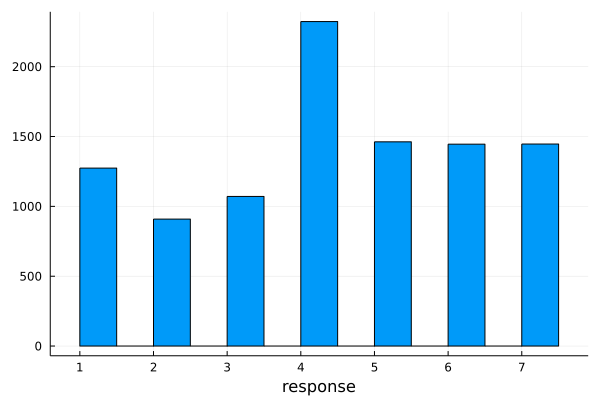

In [14]:
histogram(d.response, xlab="response")

Code 12.14

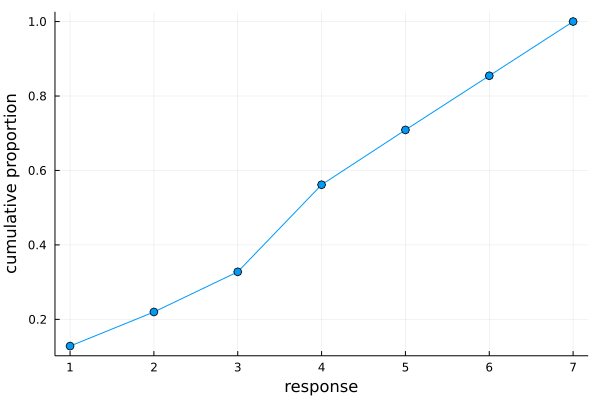

In [15]:
pr_k = counts(d.response) / length(d.response)
cum_pr_k = cumsum(pr_k)
plot(cum_pr_k, m=:o, xlab="response", ylab="cumulative proportion")

Code 12.15

In [16]:
round.(logit.(cum_pr_k), digits=2)

7-element Vector{Float64}:
 -1.92
 -1.27
 -0.72
  0.25
  0.89
  1.77
 Inf

Code 12.16

In [17]:
@model function m12_4(R)
    # to ensure sorted cutpoints, use deltas
    Δ_cutpoints ~ filldist(Exponential(), 6)
    cutpoints = -2 .+ cumsum(Δ_cutpoints)
    R .~ OrderedLogistic(0, cutpoints)
end

m12_4 (generic function with 2 methods)

Code 12.18

In [18]:
Random.seed!(1)
m12_4_ch = sample(m12_4(d.response), NUTS(), 1000)
m12_4_df = DataFrame(m12_4_ch)
precis(m12_4_df)
cutpoints = -2 .+ cumsum(mean.(eachcol(m12_4_df[!,r"Δ.*"])))

┌────────────────┬───────────────────────────────────────────────────────┐
│          param │   mean     std    5.5%     50%   94.5%      histogram │
├────────────────┼───────────────────────────────────────────────────────┤
│ Δ_cutpoints[1] │ 0.0832  0.0288  0.0366  0.0831  0.1298      ▁▂▅█▇▆▄▁▁ │
│ Δ_cutpoints[2] │ 0.6488  0.0211  0.6144  0.6488  0.6823       ▁▂▇█▆▂▁▁ │
│ Δ_cutpoints[3] │ 0.5486  0.0155  0.5224  0.5493  0.5736     ▁▁▃▆██▅▃▁▁ │
│ Δ_cutpoints[4] │  0.967  0.0177  0.9395  0.9668  0.9943  ▁▁▁▂▄███▆▃▁▁▁ │
│ Δ_cutpoints[5] │  0.643  0.0151  0.6189  0.6432  0.6657    ▁▁▂▄▇█▆▃▁▁▁ │
│ Δ_cutpoints[6] │ 0.8795  0.0231  0.8402    0.88  0.9175       ▁▂▄██▄▂▁ │
└────────────────┴───────────────────────────────────────────────────────┘


6-element Vector{Float64}:
 -1.916848096044849
 -1.2680842467133162
 -0.7195018544090639
  0.2475040415196963
  0.8905126697478538
  1.7700339206951212

Code 12.19

In [19]:
round.(logistic.(cutpoints), digits=3)

6-element Vector{Float64}:
 0.128
 0.22
 0.328
 0.562
 0.709
 0.854

Code 12.20

In [20]:
pk = pdf.(OrderedLogistic(0, cutpoints), 1:7)
round.(pk, digits=2)

7-element Vector{Float64}:
 0.13
 0.09
 0.11
 0.23
 0.15
 0.15
 0.15

Code 12.21

In [21]:
sum(pk.*(1:7))

4.199678568694903

Code 12.22

In [22]:
pk = pdf.(OrderedLogistic(0, cutpoints .- 0.5), 1:7)
round.(pk, digits=2)

7-element Vector{Float64}:
 0.08
 0.06
 0.08
 0.21
 0.16
 0.18
 0.22

Code 12.23

In [23]:
sum(pk.*(1:7))

4.729934288492506

Code 12.24

In [24]:
@model function m12_5(R, A, I, C)
    # to ensure sorted cutpoints, use deltas
    Δ_cutpoints ~ filldist(Exponential(), 6)
    cutpoints = -3 .+ cumsum(Δ_cutpoints)
    
    bA ~ Normal(0, 0.5)
    bI ~ Normal(0, 0.5)
    bC ~ Normal(0, 0.5)
    bIA ~ Normal(0, 0.5)
    bIC ~ Normal(0, 0.5)
    BI = @. bI + bIA*A + bIC*C
    phi = @. bA*A + bC*C + BI*I
    
    for i in eachindex(R)
        R[i] ~ OrderedLogistic(phi[i], cutpoints)
    end
end

Random.seed!(2)
m12_5_ch = sample(m12_5(d.response, d.action, d.intention, d.contact), NUTS(), 1000)
m12_5_df = DataFrame(m12_5_ch)
precis(m12_5_df)
#cutpoints = -2 .+ cumsum(mean.(eachcol(m12_5_df[!,r"Δ.*"])))

┌────────────────┬───────────────────────────────────────────────────────────┐
│          param │    mean     std     5.5%      50%    94.5%      histogram │
├────────────────┼───────────────────────────────────────────────────────────┤
│             bA │ -0.4746  0.0567  -0.5595  -0.4731  -0.3832      ▁▁▂▆█▆▂▁▁ │
│             bC │ -0.3462   0.071  -0.4591  -0.3459  -0.2319    ▁▁▂▅██▅▃▁▁▁ │
│             bI │ -0.2916   0.061   -0.389  -0.2904  -0.1938       ▁▁▄██▅▂▁ │
│            bIA │ -0.4352  0.0824   -0.563  -0.4357  -0.3061  ▁▁▁▃▆███▄▂▁▁▁ │
│            bIC │ -1.2356  0.0952  -1.3861  -1.2322  -1.0772       ▁▁▁▅█▇▂▁ │
│ Δ_cutpoints[1] │  0.3634  0.0535   0.2762    0.364   0.4444       ▁▁▂▇█▅▁▁ │
│ Δ_cutpoints[2] │  0.6959   0.023   0.6608   0.6958   0.7332       ▁▂▅██▃▁▁ │
│ Δ_cutpoints[3] │  0.5947  0.0167   0.5689   0.5942   0.6209    ▁▁▂▅▇█▇▅▂▁▁ │
│ Δ_cutpoints[4] │  1.0347  0.0203   1.0025   1.0343   1.0664  ▁▁▂▃▆▇█▇▅▃▂▁▁ │
│ Δ_cutpoints[5] │  0.6708  0.0162   0.6443   0.6707

Code 12.25

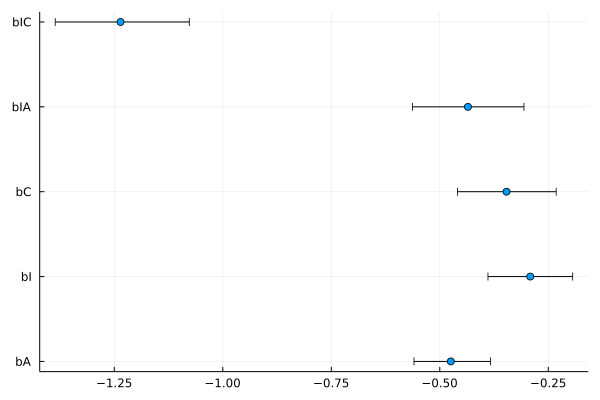

In [25]:
coeftab_plot(m12_5_df, pars=[:bIC, :bIA, :bC, :bI, :bA])

Code 12.26

(not needed, in fact)

In [26]:
#p = plot(xlab="intention", ylab="probability", xlim=(0, 1), ylim=(0, 1))

Code 12.27

In [27]:
kA = 0      # value for action
kC = 0      # value for contact
kI = 0:1    # values for intention to calculate over

rI_to_phi = (r, i) -> begin
    BI = r.bI + r.bIA*kA + r.bIC*kC
    r.bA*kA + r.bC*kC + BI*i
end

phi = link(m12_5_df, rI_to_phi, kI);

Code 12.28

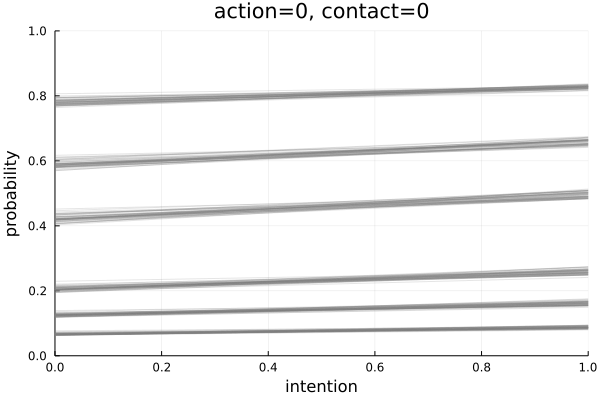

In [28]:
p = plot(xlab="intention", ylab="probability", xlim=(0, 1), ylim=(0, 1), title="action=$kA, contact=$kC")
for ri in 1:50
    r = m12_5_df[ri,:]
    cutpoints = -3 .+ cumsum(r[r"Δ.*"])
    pk1 = cumsum(pdf.(OrderedLogistic(phi[1][ri], cutpoints), 1:6))
    pk2 = cumsum(pdf.(OrderedLogistic(phi[2][ri], cutpoints), 1:6))
    for i ∈ 1:6
        plot!(kI, [pk1[i], pk2[i]], c=:gray, alpha=0.2)
    end
end
p

Code 12.29

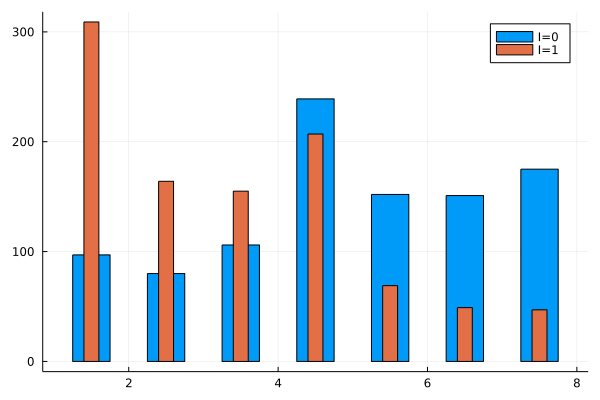

In [29]:
kA = 0
kC = 1
kI = 0:1

rI_to_dist = (r, i) -> begin
    BI = r.bI + r.bIA*kA + r.bIC*kC
    phi = r.bA*kA + r.bC*kC + BI*i
    cutpoints = -3 .+ cumsum(r[r"Δ.*"])
    OrderedLogistic(phi, cutpoints)
end

Random.seed!(1)
s = simulate(m12_5_df, rI_to_dist, kI)
histogram(map(first, s), bar_width=0.5, label="I=0")
histogram!(map(last, s), bar_width=0.2, label="I=1")

# 12.4 Ordered categorical predictors